### **Importing the Required Libraries**

In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image 
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import Flatten
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.callbacks import EarlyStopping
import pandas as pd

### **Loading Dataset from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/MyDrive/Colab Notebooks/CV_Assignment03/intel-image-classification.zip' -d '/content/'

### **Creating the Model (Using Transfer Learning)**

In [ ]:
model = VGG19(
    include_top = False,
    input_shape = (150,150,3),
    weights = 'imagenet')

for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(6, activation = 'softmax')(class1)

model = Model(inputs = model.input, outputs = output)
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### **Data Directories**

In [ ]:
training_dir = '/content/intel-image-classification/seg_train' 
testing_dir =  '/content/intel-image-classification/seg_test'
prediction_dir = '/content/intel-image-classification/seg_pred'

### **Data Preprocessing**

In [ ]:
training_gen = ImageDataGenerator(rescale = 1./255) #normalizing

test_gen = ImageDataGenerator(rescale = 1./255)

train_generator = training_gen.flow_from_directory(
    training_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 128
)
test_generator = test_gen.flow_from_directory(
    testing_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 128
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### **Train & Test Data Plot**

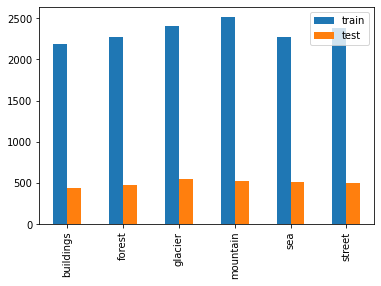

In [ ]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
_, train_counts = np.unique(train_generator.classes, return_counts=True)
_, test_counts = np.unique(test_generator.classes, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts},  index=class_names).plot.bar()
plt.show()

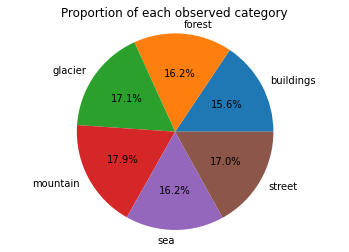

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

### **Training the Model**

In [ ]:
### Early Stopping ###
e_s = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)

def adaptive_learning_rate(epoch):
  return 0.0001*epoch

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)

acc_history = model.fit(
    train_generator,
    steps_per_epoch = 110,
    epochs = 50,
    validation_data = test_generator,
    validation_steps = 24,
    verbose = 2,
    callbacks = [e_s, lr_scheduler]
)

Epoch 1/50
110/110 - 47s - loss: 2.2354 - accuracy: 0.1597 - val_loss: 2.2525 - val_accuracy: 0.1443
Epoch 2/50
110/110 - 41s - loss: 0.7055 - accuracy: 0.7624 - val_loss: 0.4160 - val_accuracy: 0.8457
Epoch 3/50
110/110 - 43s - loss: 0.3623 - accuracy: 0.8690 - val_loss: 0.3689 - val_accuracy: 0.8643
Epoch 4/50
110/110 - 43s - loss: 0.3072 - accuracy: 0.8891 - val_loss: 0.3640 - val_accuracy: 0.8700
Epoch 5/50
110/110 - 44s - loss: 0.2548 - accuracy: 0.9067 - val_loss: 0.3566 - val_accuracy: 0.8697
Epoch 6/50
110/110 - 44s - loss: 0.2200 - accuracy: 0.9206 - val_loss: 0.4021 - val_accuracy: 0.8557
Epoch 7/50
110/110 - 44s - loss: 0.1856 - accuracy: 0.9326 - val_loss: 0.3849 - val_accuracy: 0.8693
Epoch 8/50
110/110 - 44s - loss: 0.1657 - accuracy: 0.9396 - val_loss: 0.4264 - val_accuracy: 0.8557
Epoch 9/50
110/110 - 44s - loss: 0.1402 - accuracy: 0.9488 - val_loss: 0.4514 - val_accuracy: 0.8527
Epoch 10/50
110/110 - 44s - loss: 0.1263 - accuracy: 0.9543 - val_loss: 0.4346 - val_accura

### **Saving Weights**

In [ ]:
model.save_weights('vgg_transfer_trained_without_augmentation_wts.h5')

### **Plotting Accuracy and Loss**

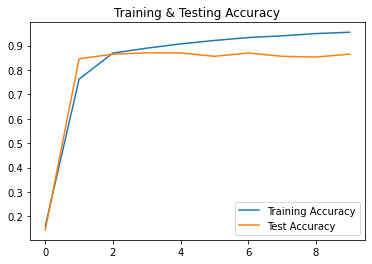

<Figure size 432x288 with 0 Axes>

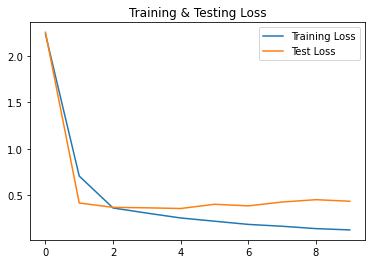

<Figure size 432x288 with 0 Axes>

In [ ]:
ac = acc_history.history['accuracy']
val_acc = acc_history.history['val_accuracy']
loss = acc_history.history['loss']
val_loss = acc_history.history['val_loss']

epochs = range(len(ac))

plt.plot(epochs, ac, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Test Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.title('Training & Testing Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### **Confusion Matrix & Classification Report**

In [ ]:
test_generator1 = test_gen.flow_from_directory(
    testing_dir,
    target_size = (150,150),
    class_mode = 'categorical',
    batch_size = 128,
    shuffle = False 
)
Y_pred = model.predict(test_generator1)
y_pred = np.argmax(Y_pred, axis=1)

print("Accuracy_test: ", accuracy_score(test_generator1.classes, y_pred))

print('\n\nConfusion Matrix')
print(confusion_matrix(test_generator1.classes, y_pred))
print('\n\nClassification Report')
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print(classification_report(test_generator1.classes, y_pred, target_names=target_names))

Found 3000 images belonging to 6 classes.
Accuracy_test:  0.8646666666666667


Confusion Matrix
[[391   0   1   2   3  40]
 [  0 460   2   6   3   3]
 [  2   0 374 141  34   2]
 [  1   0  35 474  13   2]
 [  6   1  10  61 428   4]
 [ 28   2   0   3   1 467]]


Classification Report
              precision    recall  f1-score   support

   buildings       0.91      0.89      0.90       437
      forest       0.99      0.97      0.98       474
     glacier       0.89      0.68      0.77       553
    mountain       0.69      0.90      0.78       525
         sea       0.89      0.84      0.86       510
      street       0.90      0.93      0.92       501

    accuracy                           0.86      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.86      0.86      3000



### **Predictions**

List in Alphabetical Order. Like:
[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]


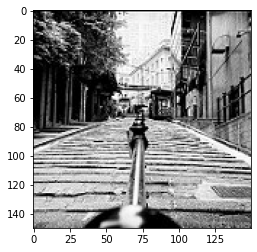

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[0 0 0 0 0 1]]


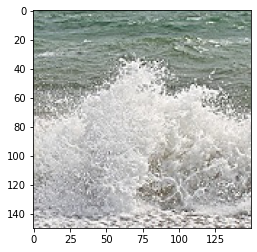

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[0 0 0 0 1 0]]


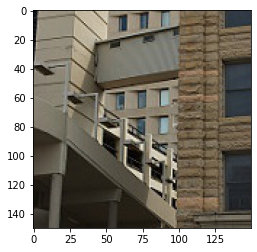

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[1 0 0 0 0 0]]


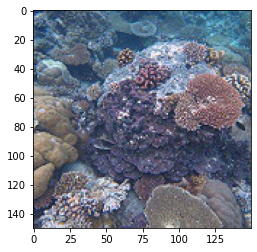

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[0 0 0 0 1 0]]


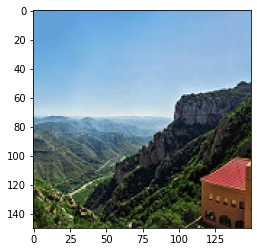

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[0 0 0 0 0 1]]


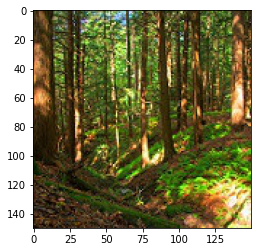

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[0 1 0 0 0 0]]


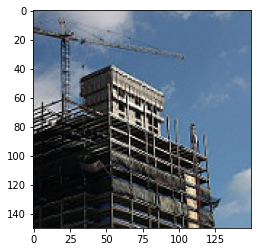

[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]
[[1 0 0 0 0 0]]


In [ ]:
print("List in Alphabetical Order. Like:")
print("[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]")
prediction_images = os.listdir(prediction_dir)

for index in range(33, 40):
  path = '/content/intel-image-classification/seg_pred/'+ prediction_images[index]
  image1 = plt.imread(path)
  plt.imshow(image1)
  plt.show() 
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  preds = preds.astype(int)
  print("[1.buildings, 2. forest, 3. glacier, 4. mountain, 5. sea, 6. street]")
  print(preds)